Observation is the projection of a pendulum to x1 axis. Dynamics are due to Newton laws. Model parameters are assumed known in advance. The task is to infer the angle of the pendulum at time t given observations $y_{1:t}$

In [1]:
using Distributions, Plots, ForwardDiff, LinearAlgebra 

In [2]:
#Generative model
delta_t = 0.05
T = 16.0
n_of_points = Int(T/delta_t)
X = zeros((2,n_of_points))
z1 = [0.33*pi]
z2 = [0.0]
r = 0.1
y = [z1[1] + sqrt(r)*randn()]
X[1,1] = z1[1]
X[2,1] = z2[1]
g = 1
q_c = 0.01
Q = [q_c*delta_t^3/3 q_c*delta_t^2/2;q_c*delta_t^2/2 q_c*delta_t]
for t=2:n_of_points
    z1_new_mu = z1[end] + z2[end]*delta_t
    z2_new_mu = z2[end] - g*sin(z1[end])*delta_t
    x_new_mu = [z1_new_mu ; z2_new_mu]
    x_new = rand(MvNormal(x_new_mu, Q))
    X[:,t] = x_new
    append!(z1, x_new[1])
    append!(z2, x_new[2])
    append!(y, z1[end]+sqrt(r)*randn())
end

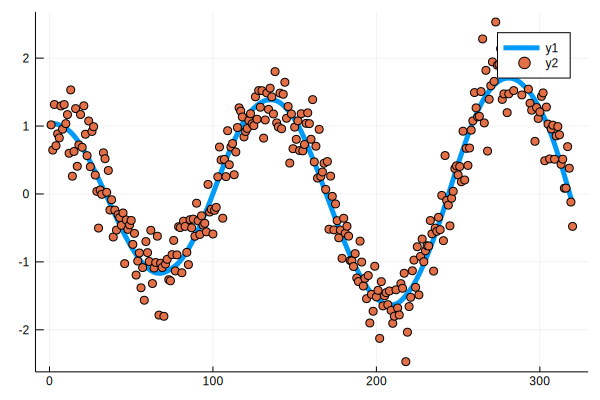

In [3]:
plot(z1,lw=5)
scatter!(y)
#plot!(5,y[5],seriestype=:scatter)
#for t=1:n_of_points
#    plot!(t,y[t],seriestype=:scatter)
#end

# Extended Kalman Filter

In [4]:
f(x) = [x[1] + x[2]*delta_t, x[2]-g*sin(x[1])*delta_t] #transition function
h(x) = sin(x[1]) #observation function
F(x) = ForwardDiff.jacobian(f,x) #Linearization around f(x)
H(x) = reshape(ForwardDiff.gradient(h,x),(1,2)); #Linearization around h(x)

In [7]:
#EKF first step
m_pred, P_pred = zeros(2), Diagonal([0.1, 0.1]) #prior
m,P = m_pred, P_pred
v = y[1] - h(m_pred)
s = (H(m_pred)*P_pred*transpose(H(m_pred)))[1] + r
k = P_pred*transpose(H(m_pred))/s
m = reshape(m_pred + k*v,2)
P = P_pred - k*s*transpose(k)
m_estimated = [m[1]]
v_ekf_estimated = [m[2]];

In [8]:
#Filtering
for t=2:n_of_points
    m_pred, P_pred = f(m), F(m)*P*transpose(F(m))+Q
    m,P = m_pred, P_pred
    v = y[t] - h(m_pred)
    s = (H(m_pred)*P_pred*transpose(H(m_pred)))[1] + r
    k = P_pred*transpose(H(m_pred))/s
    m = reshape(m_pred + k*v,2)
    P = P_pred - k*s*transpose(k)
    append!(m_estimated,m[1])
    append!(v_ekf_estimated,m[2])
end

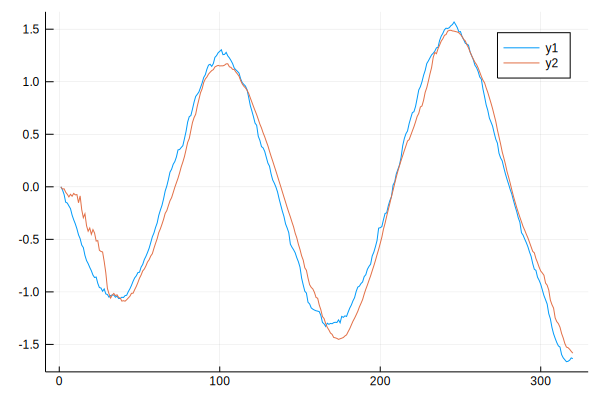

In [9]:
plot(z2)
plot!(v_ekf_estimated)

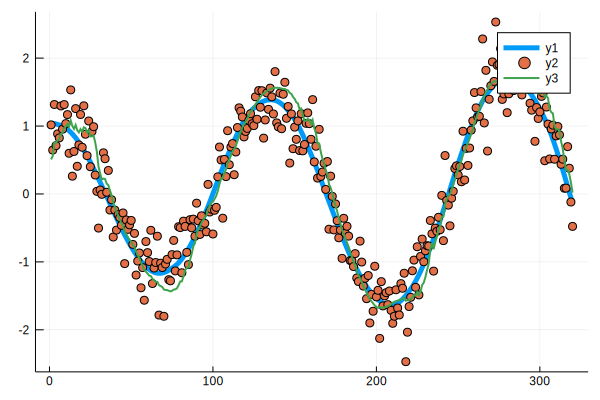

In [10]:
plot(z1,lw=5)
scatter!(y)
plot!(m_estimated,lw=2)

In [11]:
sqrt(sum((z1-m_estimated).^2))

3.5415626498772945

In [12]:
sqrt(sum((z1-y).^2))

5.66421607096656